In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### Experiment with TEN creation

In [7]:
def create_separate_tens(height, width, num_timesteps, data_movements):
    graphs = []
    positions = []
    
    # Create independent graphs for each timestep
    for t in range(num_timesteps):
        G = nx.DiGraph()
        pos = {}
        
        # Add nodes and their positions for the current timestep
        for i in range(height):
            for j in range(width):
                node_id = (i, j)
                G.add_node(node_id)
                pos[node_id] = (j, height - i)  # Regular grid positioning

        # Add edges based on chunk movements for the current timestep
        if t < num_timesteps - 1:
            for i in range(height):
                for j in range(width):
                    for (di, dj) in data_movements:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < height and 0 <= nj < width:
                            G.add_edge((i, j), (ni, nj))

        graphs.append(G)
        positions.append(pos)
    
    return graphs, positions

def draw_separate_tens(graphs, positions, width_per_graph=5):
    fig, axes = plt.subplots(1, len(graphs), figsize=(width_per_graph * len(graphs), width_per_graph))
    if len(graphs) == 1:
        axes = [axes]  # ensure axes are iterable
    
    for ax, (G, pos) in zip(axes, zip(graphs, positions)):
        nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', ax=ax, arrowsize=20, font_size=9)
        ax.set_title(f"Graph at timestep {positions.index(pos)}")

    plt.show()



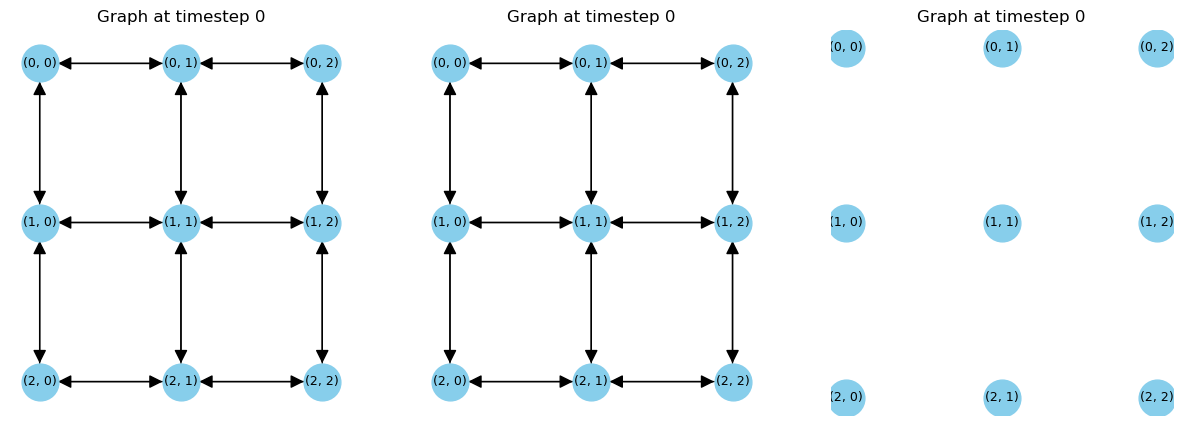

In [8]:
# Example usage
height = 3
width = 3
num_timesteps = 3
data_movements = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Directions: right, down, left, up

graphs, positions = create_separate_tens(height, width, num_timesteps, data_movements)
draw_separate_tens(graphs, positions)

### Preprocess TACOS output

In [ ]:
import csv

def preprocess_csv(input_file, output_file):
    timestep_mapping = {}
    current_timestep = 0
    
    with open(input_file, 'r') as file:
        csv_reader = csv.reader(file)
        rows = list(csv_reader)
    
    with open(output_file, 'w', newline='') as file:
        csv_writer = csv.writer(file)
        
        for row in rows:
            timestep = float(row[0])
            
            if timestep not in timestep_mapping:
                timestep_mapping[timestep] = current_timestep
                current_timestep += 1
            
            row[0] = str(timestep_mapping[timestep])
            csv_writer.writerow(row)

# input and output CSV file paths
input_file = 'build/bin/output.csv'
output_file = 'preprocessed_output.csv'

# Preprocess the CSV file
preprocess_csv(input_file, output_file)
print(f"Preprocessed CSV file created: {output_file}")

### Process the cleaned data into graph timesteps

In [17]:
# load the CSV file
df = pd.read_csv('preprocessed_output.csv')

# Get unique timesteps
timesteps = df['Timestep'].unique()

# Initialize a list to hold the graph for each timestep
graphs = []

for timestep in timesteps:
    # Filter rows belonging to the current timestep
    timestep_data = df[df['Timestep'] == timestep]
    
    # Create a directed graph for the current timestep
    G = nx.DiGraph()
    
    # Add edges to the graph
    for _, row in timestep_data.iterrows():
        source = row['source']
        destination = row['destination']
        chunkID = row['chunkID']
        G.add_edge(source, destination, chunkID=chunkID)
    
    graphs.append(G)

# Function to draw each graph
def draw_graphs(graphs):
    # Determine the number of rows needed to plot all graphs comfortably
    n_rows = len(graphs) // (3 + 1) if len(graphs) % 3 > 0 else len(graphs) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 5))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for i, G in enumerate(graphs):
        ax = axes[i]
        pos = nx.spring_layout(G)  # Position nodes using the spring layout
        labels = nx.get_edge_attributes(G, 'chunkID')
        nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', ax=ax, arrows=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
        ax.set_title(f"Timestep {i}")
        
    # Hide any unused subplot areas
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

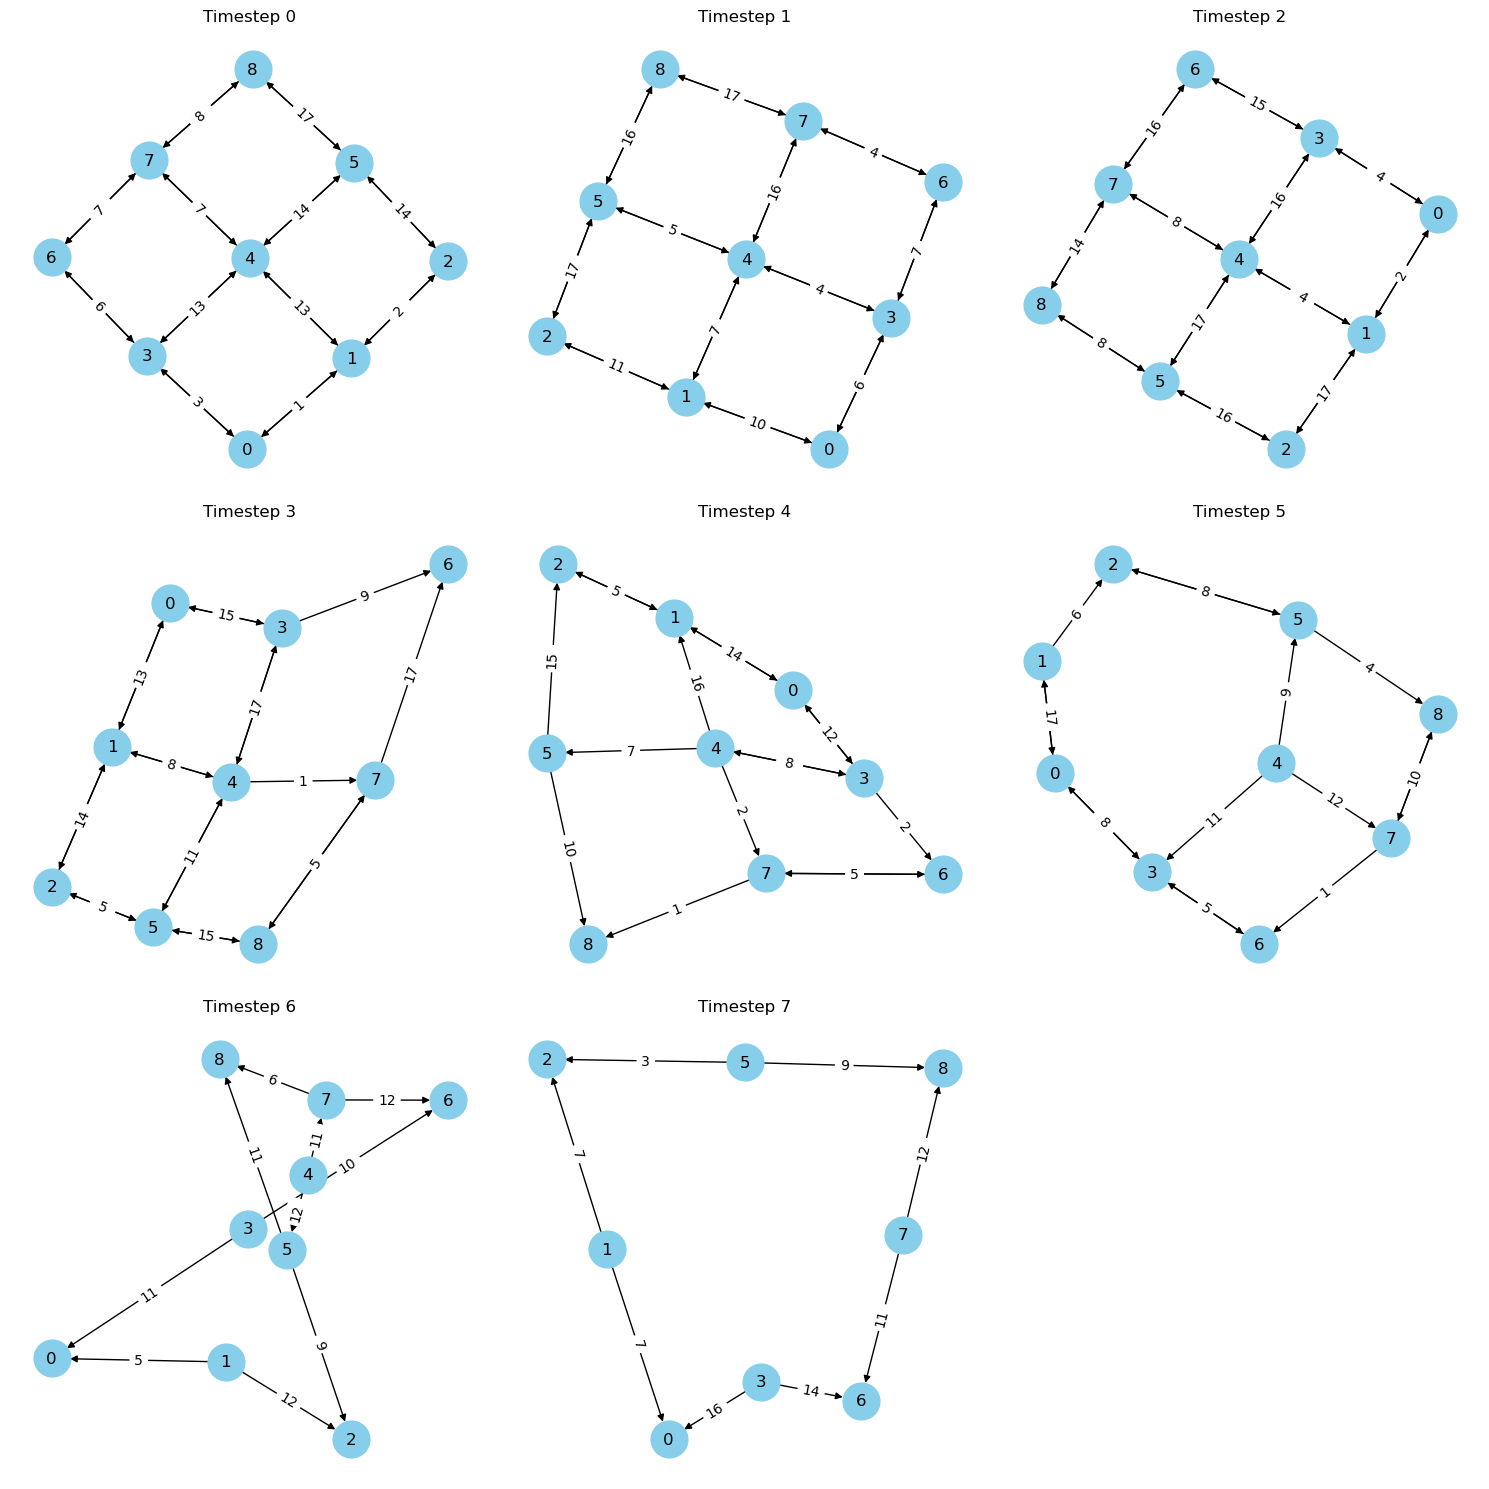

In [18]:
draw_graphs(graphs)

### Include all Nodes in 2D mesh regardless of inbound/outbound connections

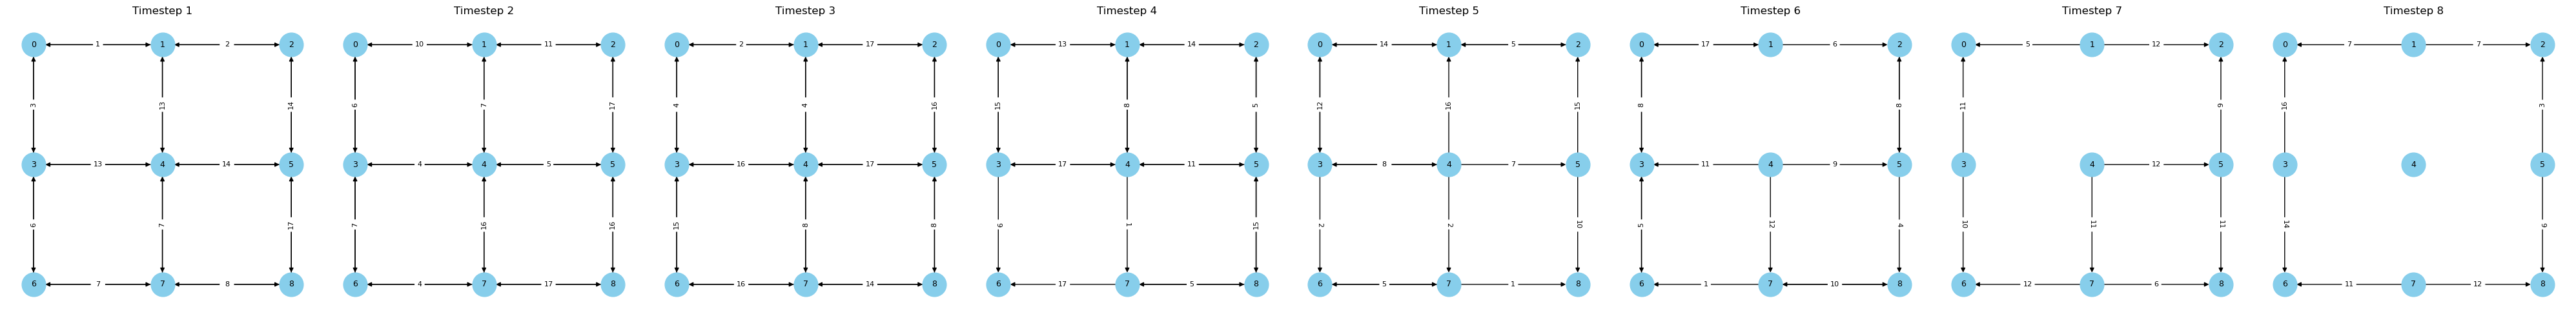

In [26]:


# Load the CSV file
df = pd.read_csv('preprocessed_output.csv')

# Assuming height and width of the mesh are known
height = 3  # Adjust as necessary based on mesh structure
width = 3   # Adjust as necessary based on mesh structure

def add_all_nodes(G, height, width):
    for i in range(height * width):  # Assuming node identifiers are from 0 to height*width-1
        G.add_node(i)

# Get unique timesteps
timesteps = df['Timestep'].unique()

graphs = []

for timestep in timesteps:
    timestep_data = df[df['Timestep'] == timestep]
    
    G = nx.DiGraph()
    add_all_nodes(G, height, width)  # Add nodes for this timestep
    
    # Directly use integer identifiers from the CSV
    for _, row in timestep_data.iterrows():
        source = row['source']
        destination = row['destination']
        chunkID = row['chunkID']
        G.add_edge(source, destination, chunkID=chunkID)
    
    graphs.append(G)

def draw_graphs(graphs, height, width):
    # Calculate figure size dynamically based on the number of graphs
    fig, axes = plt.subplots(1, len(graphs), figsize=(5 * len(graphs), 5))
    if len(graphs) == 1:
        axes = [axes]  # Make it iterable if only one graph
    
    for i, G in enumerate(graphs):
        ax = axes[i]
        pos = {}  # Dictionary to hold node positions
        
        # Define node positions based on a 2D mesh layout
        for node in G.nodes():
            row = node // width
            col = node % width
            pos[node] = (col, height - 1 - row)  # Invert y-axis to have node 0 at top left
        
        nx.draw(G, pos, with_labels=True, ax=ax, node_size=700, node_color='skyblue', arrows=True, font_size=9)
        
        # Edge labels
        edge_labels = dict(((u, v), d['chunkID']) for u, v, d in G.edges(data=True))
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=8, ax=ax)
        
        ax.set_title(f"Timestep {i + 1}")

    plt.tight_layout()
    plt.show()

# Call the draw function with the updated parameters for height and width
draw_graphs(graphs, height=3, width=3)